# Single-Cell RNA Sequencing using synthetic dataset generated from Splatter using Tensorflow 2.0
# with prime resources from https://github.com/theislab/dca

In [96]:
## Author: Rahul Bhadani

In [97]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Generate Synthetic Dataset using Splatter

The core of the Splat model is a gamma-Poisson distribution used to generate a gene by cell matrix of counts. Mean expression levels for each gene are simulated from a gamma distribution and the Biological Coefficient of Variation is used to enforce a mean-variance trend before counts are simulated from a Poisson distribution. Splat also allows you to simulate expression outlier genes (genes with mean expression outside the gamma distribution) and dropout (random knock out of counts based on mean expression). Each cell is given an expected library size (simulated from a log-normal distribution) that makes it easier to match to a given dataset. Splat can also simulate differential expression between groups of different types of cells or differentiation paths between different cells types where expression changes in a continuous way.


In [87]:
# %%R will execute R command
# -o flag gives a way to transfer R variables to Jupyter Notebook

In [88]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo
library(splatter)
# Reference: https://bioconductor.org/packages/devel/bioc/vignettes/splatter/inst/doc/splatter.html
simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups # Group Probability

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating group DE...

R[write to console]: Simulating cell means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Done!



## Let's see how our data look like:

In [89]:
counts[1:4]

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell2,0,36,0,406,27,270,216,0,126,0,...,23,224,666,0,4,165,390,0,0,104
Cell3,26,96,0,367,21,365,304,10,305,0,...,0,263,740,0,0,0,510,1471,7,100
Cell4,12,43,0,321,0,198,258,20,147,0,...,21,178,426,0,0,127,261,1609,0,104


In [90]:
type(counts[1:4])

pandas.core.frame.DataFrame

In [91]:
truecounts[1:4]

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell2,33,36,8,406,27,270,216,37,126,15,...,23,224,666,7,4,165,390,1214,5,104
Cell3,26,96,7,367,21,365,304,10,305,8,...,12,263,740,1,5,154,510,1471,7,100
Cell4,12,43,2,321,12,198,258,20,147,10,...,21,178,426,3,4,127,261,1609,3,104


In [92]:
type(truecounts[1:4])

pandas.core.frame.DataFrame

## Generating AnnData from splatter's count Data

In [93]:
import pandas as pd

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [95]:
%%time
adataNoisy = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adataNoisy.obs_names = cellinfo.Cell
adataNoisy.var_names = geneinfo.Gene

CPU times: user 3.88 ms, sys: 4.1 ms, total: 7.98 ms
Wall time: 6.08 ms


### Let's see how our data looks like

In [98]:
adataNoisy

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [99]:
adataNoisy.X

array([[  38.,    0.,   25., ..., 1571.,    7.,  169.],
       [   0.,   36.,    0., ...,    0.,    0.,  104.],
       [  26.,   96.,    0., ..., 1471.,    7.,  100.],
       ...,
       [   0.,   45.,    0., ..., 1060.,    0.,   65.],
       [   0.,   79.,    0., ..., 1244.,    0.,  106.],
       [  28.,    0.,   13., ...,  993.,    0.,  106.]], dtype=float32)

### Well, we need to filter data and normalize as well

In [100]:
sc.pp.filter_genes(adataNoisy, min_counts=1)
sc.pp.normalize_per_cell(adataNoisy)
sc.pp.log1p(adataNoisy)
sc.pp.pca(adataNoisy)
adataNoisy.X

array([[3.2299318, 0.       , 2.831584 , ..., 6.912445 , 1.69969  ,
        4.691099 ],
       [0.       , 3.4995372, 0.       , ..., 0.       , 0.       ,
        4.5404577],
       [3.1015065, 4.374409 , 0.       , ..., 7.091915 , 1.9045151,
        4.414727 ],
       ...,
       [0.       , 3.8853781, 0.       , ..., 7.0248756, 0.       ,
        4.2467628],
       [0.       , 4.4143496, 0.       , ..., 7.1595902, 0.       ,
        4.705253 ],
       [3.60019  , 0.       , 2.8639696, ..., 7.141809 , 0.       ,
        4.9111176]], dtype=float32)

In [15]:
#sc.pl.clustermap(adata, 'Group')

In [16]:
#sc.pl.clustermap(adata, 'Group')

### Lets also save the true counts for comparison as well

In [101]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)

In [102]:
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adataNoisy.var_names].copy()
adata_true
adata_true.X

array([[  38.,   89.,   25., ..., 1571.,    7.,  169.],
       [  33.,   36.,    8., ..., 1214.,    5.,  104.],
       [  26.,   96.,    7., ..., 1471.,    7.,  100.],
       ...,
       [  20.,   45.,   10., ..., 1060.,    5.,   65.],
       [  34.,   79.,    3., ..., 1244.,    4.,  106.],
       [  28.,   30.,   13., ...,  993.,    6.,  106.]], dtype=float32)

In [104]:
adata_true.obs[1:4]

,Cell,Batch,Group,ExpLibSize
Cell,,,,
Cell2,Cell2,Batch1,Group1,66491.170024
Cell3,Cell3,Batch1,Group2,72703.636528
Cell4,Cell4,Batch1,Group1,64562.865010


In [106]:
adata_true.var[1:4]

,Gene,BaseGeneMean,OutlierFactor,GeneMean,DEFacGroup1,DEFacGroup2
Gene,,,,,,
Gene2,Gene2,0.777366,1.0,0.777366,1.0,1.0
Gene3,Gene3,0.145913,1.0,0.145913,1.0,1.0
Gene4,Gene4,4.375650,1.0,4.375650,1.0,1.0


In [107]:
# Normalization
sc.pp.normalize_per_cell(adata_true)
sc.pp.log1p(adata_true)
sc.pp.pca(adata_true)

### See the scatter plot to check how we are doing

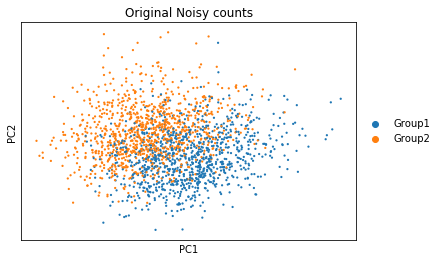

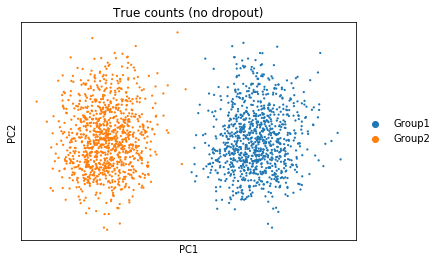

In [109]:

sc.pl.pca_scatter(adataNoisy, color='Group', size=20, title='Original Noisy counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')

In [23]:
#sc.pl.clustermap(adata, 'Group')

In [24]:
#sc.pl.clustermap(adata_true, 'Group')

# I am going to use Tensorflow 2.0 to implement autoencoder that will be used to denoise the data

In [123]:
import tensorflow as tf
import scipy as sp
import numpy as np
print(tf.version)

<module 'tensorflow_core._api.v2.version' from '/home/ivory/anaconda3/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>


In [124]:
np.random.seed(1)
tf.random.set_seed(1)

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene
sc.pp.filter_genes(adata_ae, min_counts=1)

In [125]:
adata_ae.X

array([[  38.,    0.,   25., ..., 1571.,    7.,  169.],
       [   0.,   36.,    0., ...,    0.,    0.,  104.],
       [  26.,   96.,    0., ..., 1471.,    7.,  100.],
       ...,
       [   0.,   45.,    0., ..., 1060.,    0.,   65.],
       [   0.,   79.,    0., ..., 1244.,    0.,  106.],
       [  28.,    0.,   13., ...,  993.,    0.,  106.]], dtype=float32)

In [126]:
input_size = adata_ae.n_vars
output_size = adata_ae.n_vars

In [127]:
print(type(input_size))
print(input_size)

<class 'int'>
198


In [128]:
print(adata_ae.n_obs) #2 Number of cells, i.e. samples

2000


In [129]:
#adata_ae.obs
import os, tempfile, shutil, random
# set seed for reproducibility
random_state=0
random.seed(random_state)
np.random.seed(random_state)
tf.compat.v1.set_random_seed(random_state)
os.environ['PYTHONHASHSEED'] = '0'

In [130]:

adata_ae.obs['dca_split'] = 'train'
adata_ae.obs['dca_split'] = adata_ae.obs['dca_split'].astype('category') # Convert to categorical variable to save memory

In [131]:
adata_ae.obs[1:4]

,Cell,Batch,Group,ExpLibSize,dca_split
Cell,,,,,
Cell2,Cell2,Batch1,Group1,66491.170024,train
Cell3,Cell3,Batch1,Group2,72703.636528,train
Cell4,Cell4,Batch1,Group1,64562.865010,train


In [132]:
sc.pp.filter_genes(adata_ae, min_counts = 1)
sc.pp.filter_cells(adata_ae, min_counts = 1)
adata_ae.raw = adata_ae.copy()
sc.pp.normalize_per_cell(adata_ae)
adata_ae.obs['size_factors'] = adata_ae.obs.n_counts / np.median(adata_ae.obs.n_counts)
sc.pp.log1p(adata_ae)
sc.pp.scale(adata_ae)

In [133]:
print(adata_ae.X)
print(adata_ae.X.shape)

[[ 0.902312   -1.5697504   1.8161751  ...  0.06253445  1.6440285
   0.46799985]
 [-1.0550072   0.33948302 -0.63666123 ... -6.0756736  -0.4679634
   0.38129777]
 [ 0.82448703  0.8167846  -0.63666123 ...  0.22190274  1.8985392
   0.3089332 ]
 ...
 [-1.0550072   0.54998523 -0.63666123 ...  0.1623721  -0.4679634
   0.2122608 ]
 [-1.0550072   0.8385748  -0.63666123 ...  0.28199783 -0.4679634
   0.4761462 ]
 [ 1.1266862  -1.5697504   1.8442289  ...  0.26620817 -0.4679634
   0.594632  ]]
(2000, 198)


In [134]:
adata_ae.obs[1:10]

,Cell,Batch,Group,ExpLibSize,dca_split,n_counts,size_factors
Cell,,,,,,,
Cell2,Cell2,Batch1,Group1,66491.170024,train,64216.0,1.121491
Cell3,Cell3,Batch1,Group2,72703.636528,train,70120.0,1.224600
Cell4,Cell4,Batch1,Group1,64562.865010,train,61381.0,1.071979
Cell5,Cell5,Batch1,Group1,49060.686986,train,48384.0,0.844995
Cell6,Cell6,Batch1,Group1,53130.339924,train,50737.0,0.886089
Cell7,Cell7,Batch1,Group1,61886.063295,train,56134.0,0.980344
Cell8,Cell8,Batch1,Group2,33333.046267,train,32072.0,0.560117
Cell9,Cell9,Batch1,Group1,50534.783214,train,48812.0,0.852470
Cell10,Cell10,Batch1,Group1,70243.067738,train,67702.0,1.182371


In [135]:
print(adata_ae)
print(adata_ae.n_vars)
print(adata_ae.raw.X.shape)

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
198
(2000, 198)


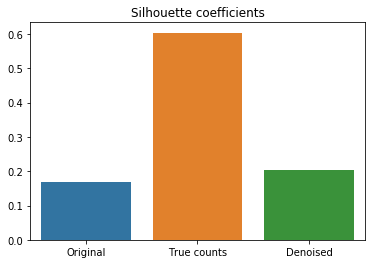

In [136]:
from sklearn.metrics import silhouette_score
sc.pp.pca(adata_ae)

sil_orig = silhouette_score(adataNoisy.obsm['X_pca'][:, :2], adataNoisy.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

## Lets create neural net layers that will compose AutoEncoder

In [137]:
Dispersion_Activation = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)
Mean_Activation = lambda x: tf.clip_by_value(tf.keras.backend.exp(x), 1e-5, 1e6) # tf.keras.backend.exp for Element-wise exponential.
ColwiseMultLayer = tf.keras.layers.Lambda(lambda l: l[0]*tf.reshape(l[1], (-1,1))) #Class Lambda Wraps arbitrary expressions as a Layer object.

In [138]:
def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

#### Single-cell data are assumed to be Zero-Inflated Negative Binomial Distribution. As a result, for Autoencoder training, Zero-Inflated Negative Binomial Distribution is used. Using the ZINB noise model, Neuralnet can learn gene-specific parameters mean, dispersion and dropout probability based on the input gene expression data. The inferred mean parameter of the distribution represents the denoised reconstruction and the output of DCA

In [139]:
# Negative Bionomial
class NB(object):
    def __init__(self, theta=None, masking=False, scope='nbinom_loss/',
                 scale_factor=1.0, debug=False):

        # for numerical stability
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.scope = scope
        self.masking = masking
        self.theta = theta

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor

            if self.masking:
                nelem = _nelem(y_true)
                y_true = _nan2zero(y_true)

            # Clip theta
            theta = tf.minimum(self.theta, 1e6)

            t1 = tf.math.lgamma(theta+eps) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+eps)
            t2 = (theta+y_true) * tf.math.log(1.0 + (y_pred/(theta+eps))) + (y_true * (tf.math.log(theta+eps) - tf.math.log(y_pred+eps)))

            if self.debug:
                assert_ops = [
                        tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                        tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]

                tf.summary.histogram('t1', t1)
                tf.summary.histogram('t2', t2)

                with tf.control_dependencies(assert_ops):
                    final = t1 + t2

            else:
                final = t1 + t2

            final = _nan2inf(final)

            if mean:
                if self.masking:
                    final = tf.divide(tf.reduce_sum(final), nelem)
                else:
                        final = tf.reduce_mean(final)


        return final

class ZINB(NB):
    def __init__(self, pi, ridge_lambda=0.0,  scope='zinb_loss/', **kwargs):
        super().__init__(scope=scope, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda

    def loss(self, y_true, y_pred, mean=True):
        scale_factor = self.scale_factor
        eps = self.eps
        
        with tf.name_scope(self.scope):
            # reuse existing NB neg.log.lik.
            # mean is always False here, because everything is calculated
            # element-wise. we take the mean only in the end
            nb_case = super().loss(y_true, y_pred, mean=False) - tf.math.log(1.0-self.pi+eps)

            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor
            theta = tf.minimum(self.theta, 1e6)

            zero_nb = tf.pow(theta/(theta+y_pred+eps), theta)
            zero_case = -tf.math.log(self.pi + ((1.0-self.pi)*zero_nb)+eps)
            result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
            ridge = self.ridge_lambda*tf.square(self.pi)
            result += ridge

            if mean:
                if self.masking:
                    result = _reduce_mean(result)
                else:
                    result = tf.reduce_mean(result)

            result = _nan2inf(result)

            if self.debug:
                tf.summary.histogram('nb_case', nb_case)
                tf.summary.histogram('zero_nb', zero_nb)
                tf.summary.histogram('zero_case', zero_case)
                tf.summary.histogram('ridge', ridge)

        return result

In [140]:
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        self.index = index
        super().__init__(**kwargs)

    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('Input should be a list')
        super().build(input_shape)

    def call(self, x):
        assert isinstance(x, list), 'SliceLayer input is not a list'
        return x[self.index]

    def compute_output_shape(self, input_shape):
        return input_shape[self.index]

#### Now we will construct Neural Network to build AutoEncoder

In [141]:
inputs_layers = tf.keras.Input(shape=(input_size,), name='count') # returns an input placeholder

size_factors_layers = tf.keras.Input(shape =(1,), name='size_factors')

x = inputs_layers
# A layer instance is callable on a tensor, and returns a tensor.
x = tf.keras.layers.Dense(64, activation=None, kernel_initializer= 'glorot_uniform', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name="enc")(x)
x = tf.keras.layers.BatchNormalization(center=True, scale=False, name="batchNormal_enc")(x)
x = tf.keras.layers.Activation('relu', name="activation_enc")(x)

x = tf.keras.layers.Dense(32, activation=None,  kernel_initializer= 'glorot_uniform', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name="center")(x)
x = tf.keras.layers.BatchNormalization(center=True, scale=False, name="batchNormal_center")(x)
x = tf.keras.layers.Activation('relu', name="activation_center")(x)

x = tf.keras.layers.Dense(64, activation=None,  kernel_initializer= 'glorot_uniform', 
                            kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name="dec")(x)
x = tf.keras.layers.BatchNormalization(center=True, scale=False, name="batchNormal_dec")(x)
x =tf.keras.layers.Activation('relu', name="activation_dec")(x)

decoder_outputs = x
    
pi =  tf.keras.layers.Dense(output_size, activation='sigmoid', kernel_initializer='glorot_uniform',
                       kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name='pi')(decoder_outputs)

disp = tf.keras.layers.Dense(output_size, activation=Dispersion_Activation, kernel_initializer='glorot_uniform',
                   kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name='dispersion')(decoder_outputs)

mean = tf.keras.layers.Dense(output_size, activation=Mean_Activation, kernel_initializer='glorot_uniform',
                       kernel_regularizer=tf.keras.regularizers.l1_l2(0.0, 0.0), name='mean')(decoder_outputs)

output = ColwiseMultLayer([mean, size_factors_layers])

output = SliceLayer(0, name='slice')([output, disp, pi])
    


In [142]:
zinb = ZINB(pi, theta=disp, ridge_lambda=0.0, debug=False)

In [143]:
model = tf.keras.Model(inputs=[inputs_layers, size_factors_layers], outputs=output)
optimizer = tf.keras.optimizers.RMSprop(lr = 1e-06, clipvalue = 5.)

In [144]:
zinb.loss

<bound method ZINB.loss of <__main__.ZINB object at 0x7f998fb21cc0>>

In [146]:
## These are extra models that are needed if we want to predict parameters of ZINB Model
pi_prediction = tf.keras.Model(inputs=inputs_layers, outputs=pi)
dispersion_prediction = tf.keras.Model(inputs=inputs_layers, outputs=disp)
mean_prediction = tf.keras.Model(inputs=inputs_layers, outputs=mean)
decode_prediction = tf.keras.Model(inputs=inputs_layers, outputs=decoder_outputs)

In [147]:
model.compile(
    optimizer='adam', 
    loss=zinb.loss
)

In [148]:
# Callbacks
callbacks = []
reduce_lr = 10
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=reduce_lr, verbose=True)
callbacks.append(lr_cb)

early_stop=15
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop, verbose=True)
callbacks.append(es_cb)

In [150]:
## This is just an example of custom callback, we are not using it.
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

    def on_test_batch_begin(self, batch, logs=None):
        print('Evaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_test_batch_end(self, batch, logs=None):
        print('Evaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))


In [151]:
# Print the model summary to see if everything is okay
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
count (InputLayer)              [(None, 198)]        0                                            
__________________________________________________________________________________________________
enc (Dense)                     (None, 64)           12736       count[0][0]                      
__________________________________________________________________________________________________
batchNormal_enc (BatchNormaliza (None, 64)           192         enc[0][0]                        
__________________________________________________________________________________________________
activation_enc (Activation)     (None, 64)           0           batchNormal_enc[0][0]            
____________________________________________________________________________________________

#### Now, we will train the AutoEnoder with Early Stopping  and Reduce Learning Rate on Plateu

In [152]:
inputs = {'count': adata_ae.X, 'size_factors': adata_ae.obs.size_factors}
outputs =  adata_ae.raw.X
    
model.fit(inputs,  outputs, epochs=1800, batch_size=32, shuffle=True, validation_split = 0.1, verbose=True,  callbacks=callbacks)

Train on 1800 samples, validate on 200 samples
Epoch 1/1800
1800/1800 [==============================] - 3s 1ms/sample - loss: 74.6184 - val_loss: 74.6955
Epoch 2/1800
1800/1800 [==============================] - 1s 402us/sample - loss: 18.0568 - val_loss: 36.3929
Epoch 3/1800
1800/1800 [==============================] - 1s 397us/sample - loss: 10.2401 - val_loss: 17.9279
Epoch 4/1800
1800/1800 [==============================] - 1s 278us/sample - loss: 7.9643 - val_loss: 11.0036
Epoch 5/1800
1800/1800 [==============================] - 0s 209us/sample - loss: 6.9759 - val_loss: 8.1635
Epoch 6/1800
1800/1800 [==============================] - 0s 208us/sample - loss: 6.4492 - val_loss: 6.9916
Epoch 7/1800
1800/1800 [==============================] - 0s 206us/sample - loss: 6.1278 - val_loss: 6.4311
Epoch 8/1800
1800/1800 [==============================] - 0s 205us/sample - loss: 5.9143 - val_loss: 6.0826
Epoch 9/1800
1800/1800 [==============================] - 0s 123us/sample - loss: 5.

1800/1800 [==============================] - 0s 210us/sample - loss: 3.9511 - val_loss: 4.0793
Epoch 74/1800
1800/1800 [==============================] - 0s 205us/sample - loss: 3.9437 - val_loss: 4.0497
Epoch 75/1800
1800/1800 [==============================] - 0s 206us/sample - loss: 3.9324 - val_loss: 4.0392
Epoch 76/1800
1800/1800 [==============================] - 0s 199us/sample - loss: 3.9249 - val_loss: 4.0628
Epoch 77/1800
1800/1800 [==============================] - 0s 202us/sample - loss: 3.9225 - val_loss: 4.0303
Epoch 78/1800
1800/1800 [==============================] - 0s 201us/sample - loss: 3.9129 - val_loss: 4.0154
Epoch 79/1800
1800/1800 [==============================] - 0s 201us/sample - loss: 3.9050 - val_loss: 4.0293
Epoch 80/1800
1800/1800 [==============================] - 0s 204us/sample - loss: 3.9008 - val_loss: 4.0108
Epoch 81/1800
1800/1800 [==============================] - 0s 202us/sample - loss: 3.8889 - val_loss: 3.9884
Epoch 82/1800
1800/1800 [========

Epoch 148/1800
1800/1800 [==============================] - 0s 197us/sample - loss: 3.6184 - val_loss: 3.6966
Epoch 149/1800
1800/1800 [==============================] - 0s 199us/sample - loss: 3.6147 - val_loss: 3.6992
Epoch 150/1800
1800/1800 [==============================] - 0s 206us/sample - loss: 3.6157 - val_loss: 3.6803
Epoch 151/1800
1800/1800 [==============================] - 0s 203us/sample - loss: 3.6080 - val_loss: 3.6800
Epoch 152/1800
1800/1800 [==============================] - 0s 189us/sample - loss: 3.6091 - val_loss: 3.6925
Epoch 153/1800
1800/1800 [==============================] - 0s 200us/sample - loss: 3.6030 - val_loss: 3.6728
Epoch 154/1800
1800/1800 [==============================] - 0s 192us/sample - loss: 3.6075 - val_loss: 3.6767
Epoch 155/1800
1800/1800 [==============================] - 0s 192us/sample - loss: 3.6024 - val_loss: 3.6740
Epoch 156/1800
1800/1800 [==============================] - 0s 196us/sample - loss: 3.6027 - val_loss: 3.6659
Epoch 157/

1800/1800 [==============================] - 0s 201us/sample - loss: 3.5402 - val_loss: 3.6058
Epoch 223/1800
1800/1800 [==============================] - 0s 192us/sample - loss: 3.5385 - val_loss: 3.6092
Epoch 224/1800
1800/1800 [==============================] - 0s 192us/sample - loss: 3.5422 - val_loss: 3.6070
Epoch 225/1800
1800/1800 [==============================] - 0s 197us/sample - loss: 3.5387 - val_loss: 3.5969
Epoch 226/1800
1800/1800 [==============================] - 0s 195us/sample - loss: 3.5378 - val_loss: 3.6006
Epoch 227/1800
1800/1800 [==============================] - 0s 193us/sample - loss: 3.5386 - val_loss: 3.6005
Epoch 228/1800
1800/1800 [==============================] - 0s 198us/sample - loss: 3.5371 - val_loss: 3.5986
Epoch 229/1800
1800/1800 [==============================] - 0s 194us/sample - loss: 3.5356 - val_loss: 3.6017
Epoch 230/1800
1800/1800 [==============================] - 0s 194us/sample - loss: 3.5356 - val_loss: 3.6002
Epoch 231/1800
1800/1800 

## As a reminder, let's see how our data looks like

In [155]:
adata_ae.X
sc.pp.pca(adata_ae)

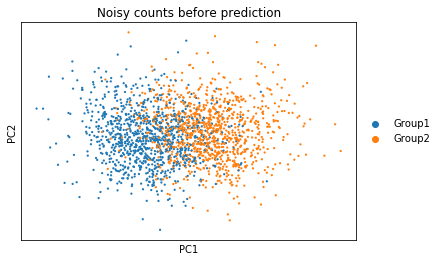

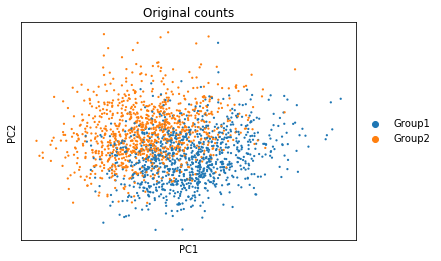

In [156]:

sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Noisy counts before prediction')
sc.pl.pca_scatter(adataNoisy, color='Group', size=20, title='Original counts')


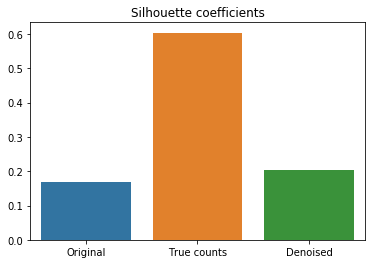

In [157]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adataNoisy.obsm['X_pca'][:, :2], adataNoisy.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

## Now we will make prediction using the model we just got. 

In [158]:
adata_ae.X = model.predict({'count': adata_ae.X,'size_factors': adata_ae.obs.size_factors})
#adata_ae.uns['dca_loss'] = model.test_on_batch({'count': adata_ae.X, 'size_factors': adata_ae.obs.size_factors}, adata_ae.raw.X)
    

In [159]:
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)


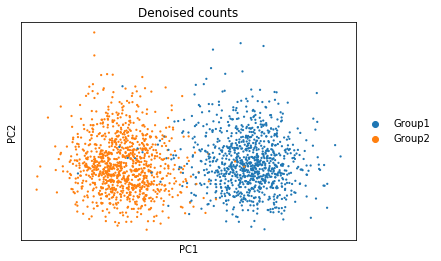

In [160]:
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')


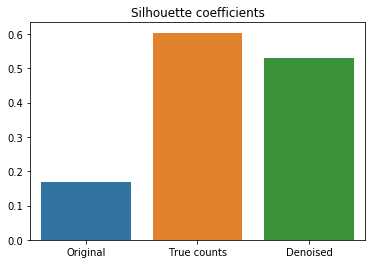

In [161]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adataNoisy.obsm['X_pca'][:, :2], adataNoisy.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [60]:
adata_ae.X

array([[3.2792733, 3.8255002, 2.701237 , ..., 7.0257635, 2.3769226,
        4.703691 ],
       [3.4052122, 4.001412 , 2.254256 , ..., 7.008899 , 1.6224569,
        4.711489 ],
       [3.2050388, 4.164026 , 2.6893725, ..., 7.090055 , 2.116159 ,
        4.6457176],
       ...,
       [3.2251573, 4.091542 , 2.4030528, ..., 7.0187488, 2.0868993,
        4.5953074],
       [3.445664 , 4.1839566, 2.8712437, ..., 7.069356 , 2.1877153,
        4.745717 ],
       [3.4018903, 4.0129943, 2.6134923, ..., 7.0418286, 1.3180801,
        4.7463865]], dtype=float32)

### From Scatter plot and Silhouette coefficients bar plot, we see that a significant improvment has been made. 